In [2]:
# ============================================================
# GoldTechETF - Final Project (with Monte Carlo, Backtesting, Fees)
# ============================================================
# Overview:
# 1) Download historical weekly data and construct signals & weights
# 2) General backtest function (works for historical or simulated data)
# 3) Fee modeling: management fee + performance fee (on excess return vs benchmark)
# 4) Monte Carlo simulation (parametric & block bootstrap methods)
# 5) Metrics: Annualized Return, Volatility, Sharpe, Alpha, Beta (relative to SPY)
# 6) Visualizations: cumulative returns, gold signal, weights heatmap, Monte Carlo histograms
# ------------------------------------------------------------
# Dependencies: pandas, numpy, matplotlib, seaborn, yfinance
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [3]:
# ============ Global Parameters ============
TECH_TICKERS = ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN']   # Selected tech stocks
GOLD_TICKER = 'GLD'
VIX_TICKER  = '^VIX'
SPY_TICKER  = 'SPY'       # Benchmark
ALL_TICKERS = TECH_TICKERS + [GOLD_TICKER, VIX_TICKER, SPY_TICKER]

START_DATE  = '1999-01-01'
END_DATE    = '2024-12-31'

# Signal parameters
MOMENTUM_LOOKBACK_W = 1         # Momentum lookback (1 week)
TOP_K_TECH = 3                   # Number of tech stocks selected each week
GOLD_SMA_W = 5                   # SMA window for gold (5 weeks)
VIX_THLD   = 20.0                # VIX threshold
VIX_MAX    = 50.0                # Upper bound for scaling gold weight
SEED       = 42

np.random.seed(SEED)

In [4]:
# ============ Utility Functions ============

def download_weekly_prices(tickers, start=START_DATE, end=END_DATE):
    """
    Download adjusted close prices, resampled to weekly frequency (Fridays).
    Returns DataFrame with tickers as columns.
    """
    raw = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)['Close']
    if isinstance(raw, pd.Series):
        raw = raw.to_frame()
    weekly = raw.resample('W-FRI').last().dropna(how='all')
    weekly = weekly.dropna(axis=1, how='all')
    return weekly

def compute_signals(weekly_prices, tech_tickers=TECH_TICKERS, gold_ticker=GOLD_TICKER,
                    vix_ticker=VIX_TICKER, momentum_lookback=MOMENTUM_LOOKBACK_W,
                    gold_sma_w=GOLD_SMA_W, vix_thld=VIX_THLD, vix_max=VIX_MAX):
    """
    Construct trading signals:
      - Tech momentum: select top-K tech stocks each week
      - Gold signal: GLD > SMA and VIX > threshold
      - Dynamic gold weight: scaled by (VIX-threshold)/(max-threshold)
    """
    cols_present = [c for c in tech_tickers if c in weekly_prices.columns]
    if len(cols_present) < TOP_K_TECH:
        raise ValueError(f"Not enough tech tickers present in data. Have {len(cols_present)}: {cols_present}")

    tech_mom = weekly_prices[cols_present].pct_change(momentum_lookback)
    top_selection = tech_mom.apply(lambda row: row.dropna().nlargest(TOP_K_TECH).index.tolist(), axis=1)

    gold_sma = weekly_prices[gold_ticker].rolling(window=gold_sma_w).mean()
    gold_above_sma = weekly_prices[gold_ticker] > gold_sma

    # VIX Filter
    vix_ser = weekly_prices[vix_ticker]
    vix_filter = vix_ser > vix_thld

    gold_signal = (gold_above_sma.fillna(False) & vix_filter.fillna(False))

    vix_scaled = ((vix_ser - vix_thld).clip(lower=0)) / max(1e-9, (vix_max - vix_thld))
    vix_scaled = vix_scaled.clip(0, 1)
    dynamic_gold_w = gold_signal.astype(float) * vix_scaled

    return {
        "tech_momentum": tech_mom,
        "top_selection": top_selection,
        "gold_signal": gold_signal,
        "dynamic_gold_weight": dynamic_gold_w
    }

def build_weights(weekly_prices, signals, tech_tickers=TECH_TICKERS, gold_ticker=GOLD_TICKER):
    """
    Construct weekly portfolio weights:
      - Gold weight = dynamic_gold_weight
      - Remaining weight equally distributed among selected tech stocks
    """
    weights = pd.DataFrame(0.0, index=weekly_prices.index, columns=weekly_prices.columns)
    top_sel = signals['top_selection']
    dyn_g_w = signals['dynamic_gold_weight']

    for dt in weekly_prices.index:
        if dt not in top_sel.index:
            continue
        selected = top_sel.loc[dt]
        selected = [t for t in selected if t in weekly_prices.columns]
        if len(selected) == 0:
            continue
        g_w = float(dyn_g_w.get(dt, 0.0))
        g_w = np.clip(g_w, 0.0, 1.0)
        tech_w = 0.0 if g_w >= 1.0 else (1.0 - g_w) / len(selected)
        for t in selected:
            weights.at[dt, t] = tech_w
        if g_w > 0:
            if gold_ticker in weights.columns:
                weights.at[dt, gold_ticker] = g_w
    return weights

def compute_returns_from_prices(weekly_prices):
    """
    Compute next-period simple returns from weekly prices.
    """
    returns = weekly_prices.pct_change().shift(-1)
    return returns

def portfolio_backtest(weekly_prices, weights, benchmark_ticker=SPY_TICKER):
    """
    General backtest: given weekly prices and weights, compute portfolio returns
    and align with benchmark.
    """
    rets = compute_returns_from_prices(weekly_prices)
    port_rets = (weights.shift().fillna(0.0) * rets).sum(axis=1).dropna()

    if benchmark_ticker in rets.columns:
        bench = rets[benchmark_ticker].dropna()
        aligned = pd.concat([port_rets, bench], axis=1, join='inner')
        port_rets = aligned.iloc[:, 0]
        bench = aligned.iloc[:, 1]
    else:
        bench = None

    return port_rets, bench

def annualize_return(cum_ret_series):
    """
    Convert cumulative return series into annualized return (weekly frequency).
    """
    if len(cum_ret_series) < 2:
        return np.nan
    yrs = len(cum_ret_series) / 52.0
    total = cum_ret_series.iloc[-1] / cum_ret_series.iloc[0]
    return total**(1/yrs) - 1.0

def perf_metrics(port_rets, bench_rets=None, rf=0.0):
    """
    Compute key metrics:
      - Annualized return
      - Annualized volatility
      - Sharpe ratio
      - Alpha, Beta relative to benchmark
    """
    ann_vol = np.sqrt(52) * port_rets.std(ddof=0)

    port_cum = (1 + port_rets).cumprod()
    ann_ret = annualize_return(port_cum)

    sharpe = np.nan
    if ann_vol > 1e-9:
        sharpe = (ann_ret - rf) / ann_vol
    alpha = beta = np.nan
    if bench_rets is not None:
        cov = np.cov(port_rets, bench_rets)[0,1]
        var_b = np.var(bench_rets)
        if var_b > 1e-12:
            beta = cov / var_b
        mu_p = port_rets.mean()
        mu_b = bench_rets.mean()
        alpha = (mu_p - (beta * mu_b)) * 52.0

    return {
        "ann_return": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "alpha_ann": alpha,
        "beta": beta
    }

In [5]:
# ============ Fee Modeling ============

def apply_fees_to_returns(port_rets, bench_rets=None, mgmt_fee_annual=0.01, perf_fee=0.10, perf_hurdle='benchmark'):
    """
    Apply fees to weekly returns:
      - Management fee: annual fee rate, distributed weekly
      - Performance fee: applied to positive excess return vs benchmark
    """
    weekly_mgmt = mgmt_fee_annual / 52.0
    net = port_rets.copy()

    net = net - weekly_mgmt

    if perf_fee > 0 and bench_rets is not None and perf_hurdle == 'benchmark':
        active = net - bench_rets.reindex_like(net).fillna(0.0)
        perf_cut = perf_fee * active.clip(lower=0.0)
        net = net - perf_cut

    return net

In [6]:
# ============ Monte Carlo Simulation ============

def mc_simulate_parametric(weekly_prices, tickers, n_weeks, n_paths=1000):
    """
    Parametric simulation:
    Generate paths from multivariate normal distribution using historical mean/covariance of log-returns.
    Returns dict {ticker: DataFrame of simulated prices}.
    """
    prices0 = weekly_prices.iloc[-1][tickers].dropna()
    hist_logrets = np.log(weekly_prices[tickers].pct_change() + 1).dropna()
    mu = hist_logrets.mean().values
    cov = hist_logrets.cov().values

    paths = {}
    for i, tk in enumerate(tickers):
        paths[tk] = np.zeros((n_weeks+1, n_paths))
        paths[tk][0, :] = prices0[tk]

    chol = np.linalg.cholesky(cov + 1e-12*np.eye(len(tickers)))

    for t in range(1, n_weeks+1):
        z = np.random.normal(size=(len(tickers), n_paths))
        step = (mu[:, None] + chol @ z)
        r = np.exp(step) - 1.0
        for j, tk in enumerate(tickers):
            paths[tk][t, :] = paths[tk][t-1, :] * (1.0 + r[j, :])
    out = {}
    for tk in tickers:
        df = pd.DataFrame(paths[tk], index=range(n_weeks+1), columns=[f'path_{k}' for k in range(n_paths)])
        out[tk] = df
    return out

def mc_simulate_block_bootstrap(weekly_prices, tickers, n_weeks, n_paths=1000, block=4, vix_series=None):
    """
    Block bootstrap simulation:
    Sample blocks of historical returns to construct artificial price paths.
    VIX bootstrapped separately to preserve distribution of volatility spikes.
    """
    hist_prices = weekly_prices[tickers].dropna()
    hist_rets = hist_prices.pct_change().dropna()
    last_prices = hist_prices.iloc[-1]

    n = len(hist_rets)
    blocks = []
    i = 0
    while i < n:
        blocks.append(list(range(i, min(i+block, n))))
        i += block

    def sample_path_for_asset(asset):
        seq_idx = []
        while len(seq_idx) < n_weeks:
            b = blocks[np.random.randint(0, len(blocks))]
            seq_idx.extend(b)
        seq_idx = seq_idx[:n_weeks]
        return hist_rets[asset].iloc[seq_idx].values

    out = {}
    for tk in tickers:
        arr = np.zeros((n_weeks+1, n_paths))
        arr[0, :] = last_prices[tk]
        for p in range(n_paths):
            r = sample_path_for_asset(tk)
            path = np.empty(n_weeks+1)
            path[0] = last_prices[tk]
            for t in range(1, n_weeks+1):
                path[t] = path[t-1] * (1.0 + r[t-1])
            arr[:, p] = path
        out[tk] = pd.DataFrame(arr, index=range(n_weeks+1), columns=[f'path_{k}' for k in range(n_paths)])


    # Dealing with VIX: Using Block-Guided Levels (Not Returns)
    if vix_series is not None:
        vix_hist = vix_series.dropna()
        vix_vals = vix_hist.values
        blocks_v = []
        nv = len(vix_vals)
        i = 0
        while i < nv:
            blocks_v.append(list(range(i, min(i+block, nv))))
            i += block

        vix_mat = np.zeros((n_weeks+1, n_paths))
        vix_mat[0, :] = vix_hist.iloc[-1]
        for p in range(n_paths):
            seq = []
            while len(seq) < n_weeks:
                b = blocks_v[np.random.randint(0, len(blocks_v))]
                seq.extend(b)
            seq = seq[:n_weeks]
            vpath = [vix_hist.iloc[-1]]
            for t in range(n_weeks):
                vpath.append(vix_vals[seq[t]])
            vix_mat[:, p] = np.array(vpath)
        out['VIX_BOOT'] = pd.DataFrame(vix_mat, index=range(n_weeks+1), columns=[f'path_{k}' for k in range(n_paths)])

    return out

def build_weekly_df_from_mc(paths_dict, vix_name='VIX_BOOT'):
    """
    Merges the price path dictionaries output by Monte Carlo into a "pseudo-weekly price table" for backtesting.
    By default, backtests each path independently (taking columns one by one and concatenating them into a DataFrame).
    Returns: Generator, yield (path_id, weekly_prices_one_path)
    """
    # Take the column name of any asset as the path ID
    any_tk = list(paths_dict.keys())[0]
    path_ids = paths_dict[any_tk].columns.tolist()

    for pid in path_ids:
        frames = []
        for tk, df in paths_dict.items():
            if tk == vix_name:
                continue
            s = df[pid].copy()
            s.name = tk
            frames.append(s)
        weekly_prices_one = pd.concat(frames, axis=1)
        # If VIX_BOOT is provided, append as column
        if vix_name in paths_dict:
            vix_col = paths_dict[vix_name][pid].rename(VIX_TICKER)
            weekly_prices_one[VIX_TICKER] = vix_col.values
        # Construct a "week index"
        weekly_prices_one.index = pd.RangeIndex(len(weekly_prices_one))
        yield pid, weekly_prices_one

In [7]:
# ============ Visualization ============

def plot_equity_vs_benchmark(cum_port, cum_bench, title='Cumulative Returns'):
    plt.figure(figsize=(10,5))
    plt.plot(cum_port, label='Portfolio')
    if cum_bench is not None:
        plt.plot(cum_bench, label='SPY (Benchmark)', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Cumulative Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_gold_signal(signal):
    plt.figure(figsize=(10,2))
    plt.plot(signal.index, signal.astype(int), drawstyle='steps-post')
    plt.title('Gold Allocation Signal (1 = Active)')
    plt.yticks([0,1])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_weight_heatmap(weights, tech_tickers=TECH_TICKERS):
    plt.figure(figsize=(12,6))
    sub = weights[weights.columns.intersection(tech_tickers)].fillna(0.0)
    sns.heatmap(sub.T, cbar_kws={'label':'Weight'})
    plt.title('Tech Stock Weights Over Time')
    plt.xlabel('Date')
    plt.ylabel('Tech Stocks')
    plt.tight_layout()
    plt.show()

def hist_plot(data, title, xlabel):
    plt.figure(figsize=(8,4))
    plt.hist(data, bins=40, alpha=0.8)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [8]:
# ============ Main Process (Historical Backtesting + Fees + Monte Carlo) ============

def run_historical_backtest(mgmt_fee=0.01, perf_fee=0.10, show_plots=True):
    # 1) Download historical weekly prices
    weekly = download_weekly_prices(ALL_TICKERS, start=START_DATE, end=END_DATE).dropna(axis=1, how='all')
    # Ensure that necessary columns exist
    cols_needed = set(TECH_TICKERS + [GOLD_TICKER, VIX_TICKER, SPY_TICKER])
    cols_have = set(weekly.columns)
    missing = cols_needed - cols_have
    if missing:
        print("Warning - missing tickers in history:", missing)

    # 2) Constructing signals and weights
    signals = compute_signals(weekly, tech_tickers=TECH_TICKERS, gold_ticker=GOLD_TICKER,
                              vix_ticker=VIX_TICKER, momentum_lookback=MOMENTUM_LOOKBACK_W,
                              gold_sma_w=GOLD_SMA_W, vix_thld=VIX_THLD, vix_max=VIX_MAX)
    weights = build_weights(weekly, signals, tech_tickers=TECH_TICKERS, gold_ticker=GOLD_TICKER)

    # 3) Backtesting (gross returns)
    port_rets, bench_rets = portfolio_backtest(weekly, weights, benchmark_ticker=SPY_TICKER)

    # 4) Deduction
    net_rets = apply_fees_to_returns(port_rets, bench_rets, mgmt_fee_annual=mgmt_fee,
                                     perf_fee=perf_fee, perf_hurdle='benchmark')

    # 5) index
    gross_metrics = perf_metrics(port_rets, bench_rets)
    net_metrics   = perf_metrics(net_rets, bench_rets)

    # 6) chart
    if show_plots:
        plot_equity_vs_benchmark((1+port_rets).cumprod(), (1+bench_rets).cumprod(), title='Cumulative Returns (Gross)')
        plot_equity_vs_benchmark((1+net_rets).cumprod(),  (1+bench_rets).cumprod(), title='Cumulative Returns (Net of Fees)')
        plot_gold_signal(signals['gold_signal'])
        plot_weight_heatmap(weights, tech_tickers=TECH_TICKERS)

    return {
        "weekly_prices": weekly,
        "signals": signals,
        "weights": weights,
        "gross_rets": port_rets,
        "net_rets": net_rets,
        "bench_rets": bench_rets,
        "gross_metrics": gross_metrics,
        "net_metrics": net_metrics
    }

def run_monte_carlo(weekly_prices_hist,
                    mgmt_fee=0.01, perf_fee=0.10,
                    n_weeks=1300, n_paths=500,  # 约5年=260周；可改为 1300≈25年
                    method='parametric', block=4, show_plots=True):
    """
    Reuse strategies and backtesting logic on simulated prices; aggregate distribution statistics
    method: 'parametric' or 'bootstrap'
    """
    # Assets selected for simulation (excluding VIX & benchmark), VIX & SPY simulation/history will be added later
    mc_tickers = [t for t in (TECH_TICKERS + [GOLD_TICKER, SPY_TICKER]) if t in weekly_prices_hist.columns]
    if SPY_TICKER not in mc_tickers:
        mc_tickers.append(SPY_TICKER)

    if method == 'parametric':
        paths = mc_simulate_parametric(weekly_prices_hist, mc_tickers, n_weeks, n_paths=n_paths)
        # Independently bootstrap VIX to get closer to the real distribution
        vix_boot = mc_simulate_block_bootstrap(weekly_prices_hist, [], n_weeks, n_paths=n_paths, block=block,
                                               vix_series=weekly_prices_hist[VIX_TICKER] if VIX_TICKER in weekly_prices_hist.columns else None)
        if 'VIX_BOOT' in vix_boot:
            paths['VIX_BOOT'] = vix_boot['VIX_BOOT']
    else:
        # Directly bootstrap the returns of all assets, and VIX bootstrap the level alone
        paths = mc_simulate_block_bootstrap(weekly_prices_hist, mc_tickers, n_weeks, n_paths=n_paths, block=block,
                                            vix_series=weekly_prices_hist[VIX_TICKER] if VIX_TICKER in weekly_prices_hist.columns else None)

    # Backtest each path and collect net indicators
    net_ann_returns = []
    net_sharpes = []
    net_alphas  = []
    net_betas   = []

    for pid, wk in build_weekly_df_from_mc(paths):
        # Requires VIX and SPY to exist
        if VIX_TICKER not in wk.columns or SPY_TICKER not in wk.columns:
            continue

        # Constructing signals and weights
        sigs = compute_signals(wk, tech_tickers=[t for t in TECH_TICKERS if t in wk.columns],
                               gold_ticker=GOLD_TICKER, vix_ticker=VIX_TICKER,
                               momentum_lookback=MOMENTUM_LOOKBACK_W,
                               gold_sma_w=GOLD_SMA_W, vix_thld=VIX_THLD, vix_max=VIX_MAX)
        w = build_weights(wk, sigs, tech_tickers=[t for t in TECH_TICKERS if t in wk.columns], gold_ticker=GOLD_TICKER)
        port, bench = portfolio_backtest(wk, w, benchmark_ticker=SPY_TICKER)
        net = apply_fees_to_returns(port, bench, mgmt_fee_annual=mgmt_fee, perf_fee=perf_fee, perf_hurdle='benchmark')

        m = perf_metrics(net, bench)
        net_ann_returns.append(m['ann_return'])
        net_sharpes.append(m['sharpe'])
        net_alphas.append(m['alpha_ann'])
        net_betas.append(m['beta'])

    # Summary
    mc_summary = pd.DataFrame({
        'net_ann_return': net_ann_returns,
        'net_sharpe': net_sharpes,
        'net_alpha_ann': net_alphas,
        'net_beta': net_betas
    }).dropna()

    if show_plots and not mc_summary.empty:
        hist_plot(mc_summary['net_ann_return'].dropna(), 'Monte Carlo: Net Annualized Return', 'Annualized Return')
        hist_plot(mc_summary['net_sharpe'].dropna(),     'Monte Carlo: Net Sharpe',            'Sharpe')
        hist_plot(mc_summary['net_alpha_ann'].dropna(),  'Monte Carlo: Net Alpha (annualized)','Alpha (annual)')
        hist_plot(mc_summary['net_beta'].dropna(),       'Monte Carlo: Beta',                  'Beta')

    return mc_summary

=== Historical Backtest (1999–2024) ===


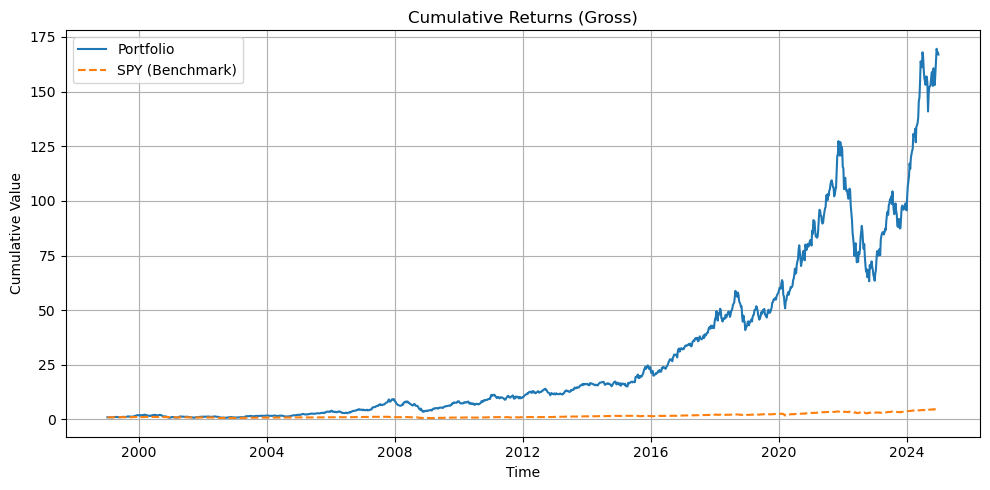

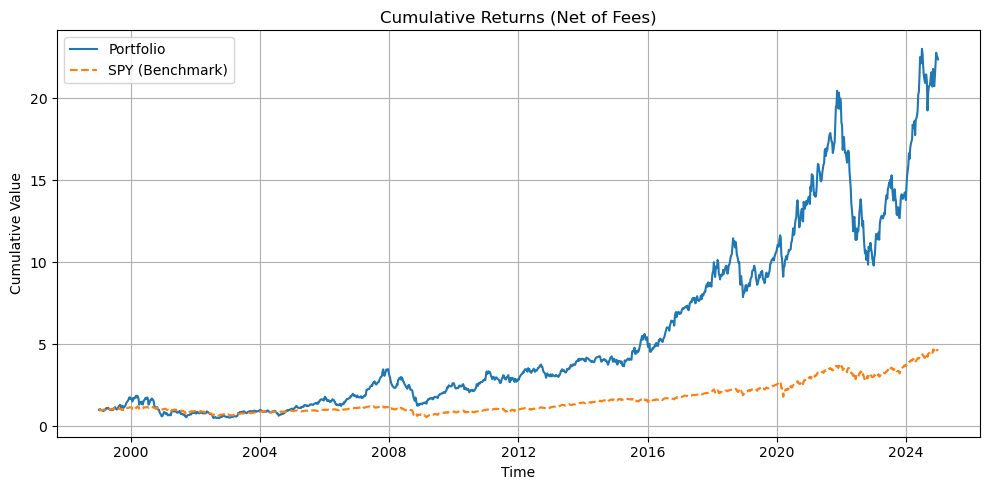

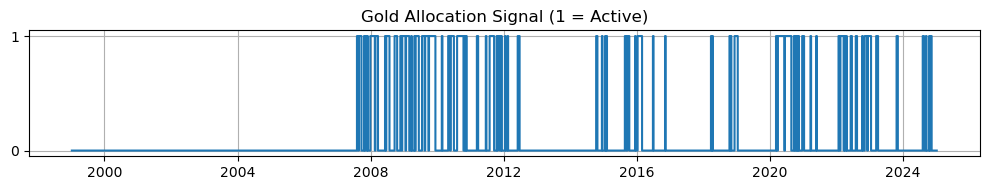

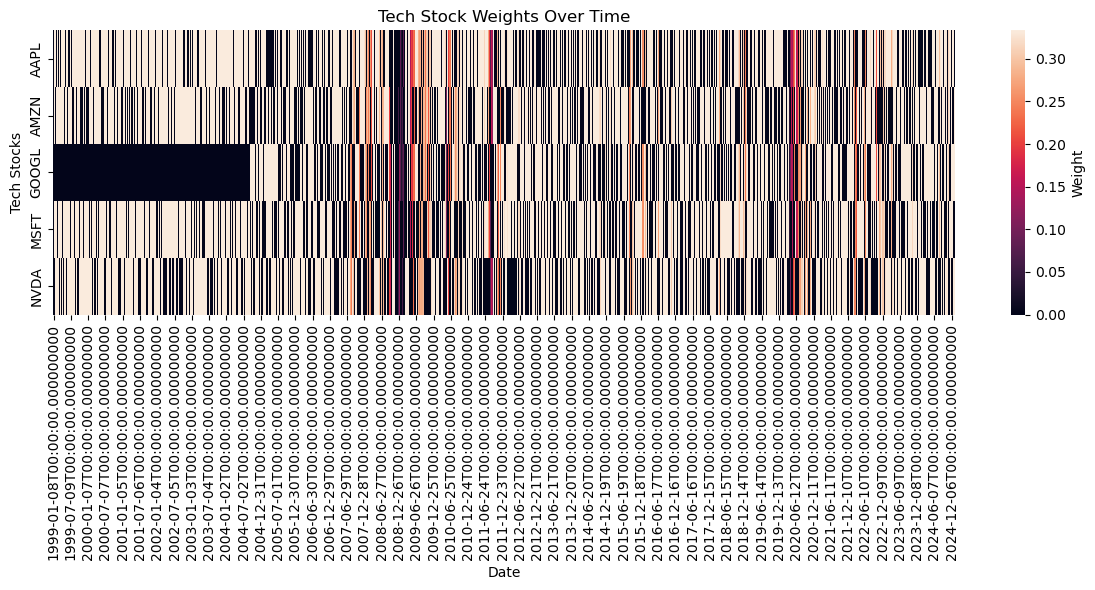


Gross Metrics:
  ann_return: 0.2168
  ann_vol: 0.3202
  sharpe: 0.6771
  alpha_ann: 0.1657
  beta: 1.0969

Net Metrics (After Fees):
  ann_return: 0.1267
  ann_vol: 0.3086
  sharpe: 0.4105
  alpha_ann: 0.0854
  beta: 1.0921

=== Monte Carlo Simulation (Parametric, 5 Years Horizon, 500 Paths) ===


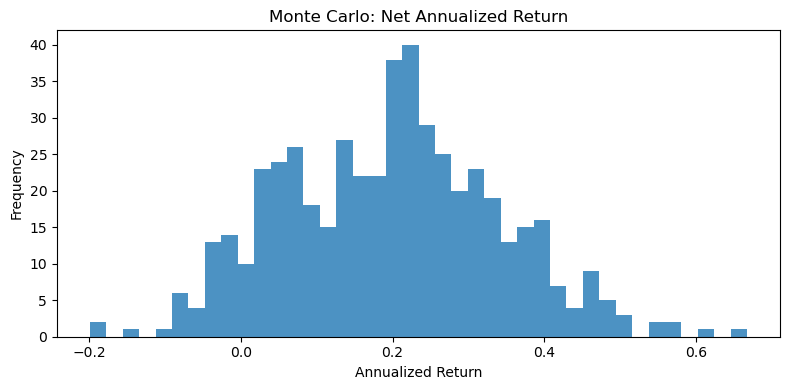

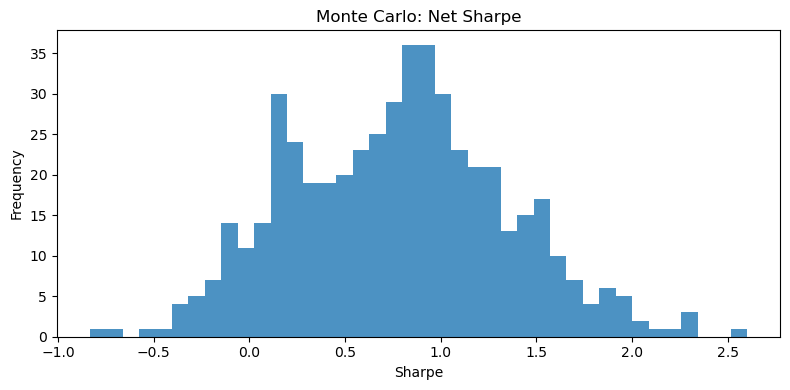

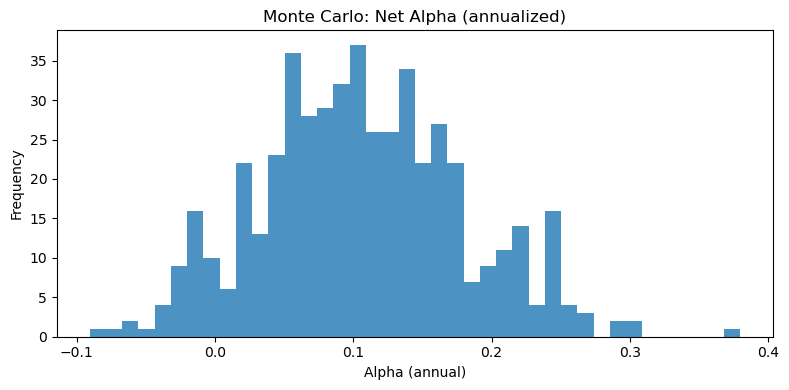

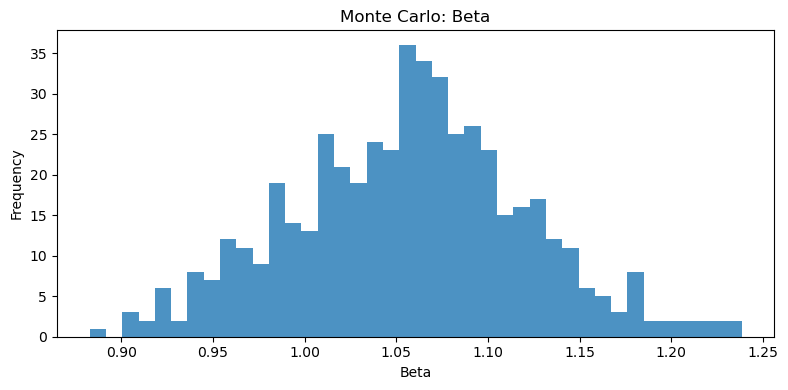


MC (Parametric) Summary:
                count      mean       std       min        5%       25%  \
net_ann_return  500.0  0.197721  0.143345 -0.199246 -0.028462  0.085807   
net_sharpe      500.0  0.782565  0.567240 -0.833482 -0.114707  0.338348   
net_alpha_ann   500.0  0.106272  0.073987 -0.090631 -0.013971  0.055628   
net_beta        500.0  1.056796  0.063874  0.882650  0.951994  1.013650   

                     50%       75%       95%       max  
net_ann_return  0.203442  0.295889  0.438959  0.667545  
net_sharpe      0.802537  1.147648  1.726301  2.602149  
net_alpha_ann   0.103125  0.155043  0.239918  0.379514  
net_beta        1.060009  1.096583  1.164071  1.238284  

=== Monte Carlo Simulation (Block Bootstrap, 5 Years Horizon, 500 Paths) ===


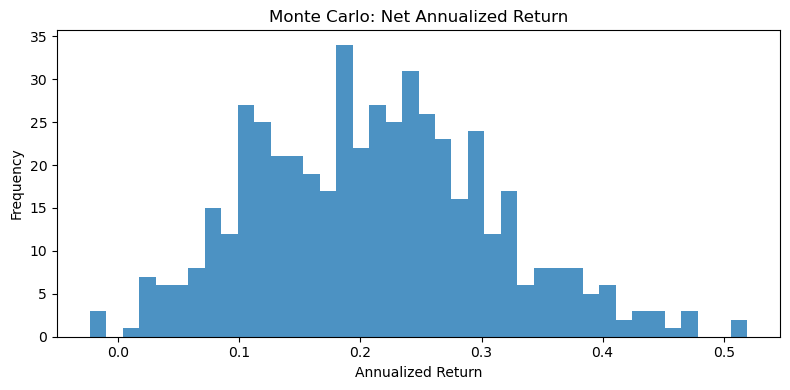

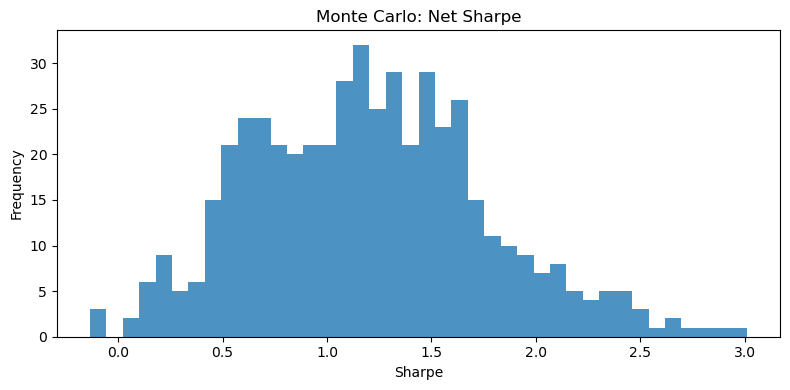

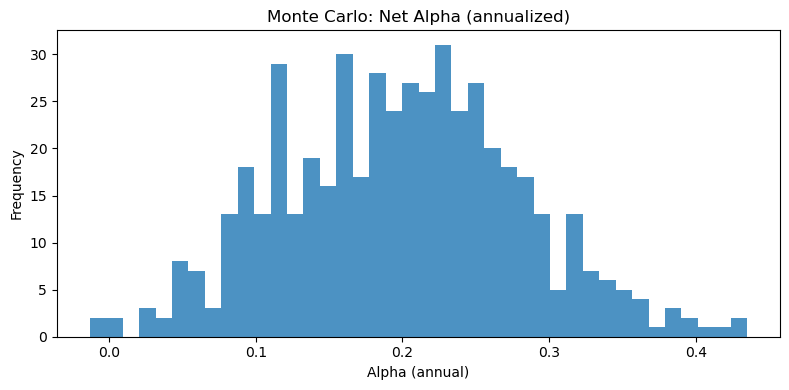

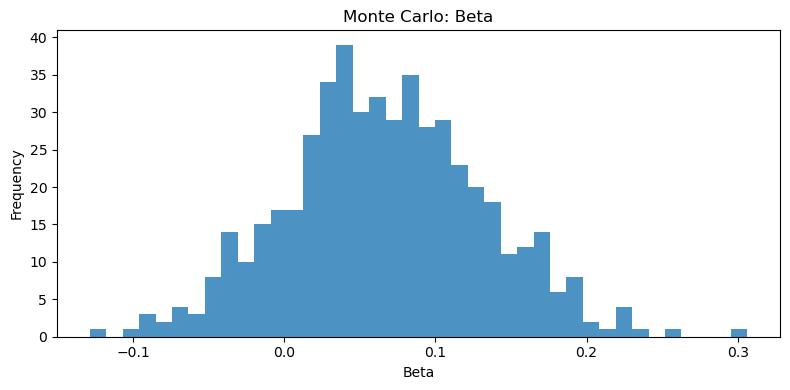


MC (Bootstrap) Summary:
                count      mean       std       min        5%       25%  \
net_ann_return  500.0  0.211961  0.098831 -0.023441  0.061645  0.134513   
net_sharpe      500.0  1.200466  0.563418 -0.135771  0.338729  0.767067   
net_alpha_ann   500.0  0.199267  0.081092 -0.013163  0.072370  0.139416   
net_beta        500.0  0.066663  0.065207 -0.128432 -0.038797  0.024188   

                     50%       75%       95%       max  
net_ann_return  0.209530  0.274588  0.382542  0.519355  
net_sharpe      1.180308  1.554928  2.175007  3.011459  
net_alpha_ann   0.201050  0.253861  0.332052  0.435077  
net_beta        0.063864  0.108981  0.173060  0.306090  


In [9]:
# ============ Main entry example =============

if __name__ == "__main__":
    # ---------- Historical backtesting (including fees) ----------
    print("=== Historical Backtest (1999–2024) ===")
    hist_out = run_historical_backtest(mgmt_fee=0.01, perf_fee=0.10, show_plots=True)
    print("\nGross Metrics:")
    for k, v in hist_out['gross_metrics'].items():
        print(f"  {k}: {v:.4f}" if v==v else f"  {k}: {v}")
    print("\nNet Metrics (After Fees):")
    for k, v in hist_out['net_metrics'].items():
        print(f"  {k}: {v:.4f}" if v==v else f"  {k}: {v}")

    # ---------- Monte Carlo Simulation----------
    print("\n=== Monte Carlo Simulation (Parametric, 5 Years Horizon, 500 Paths) ===")
    mc_summary_param = run_monte_carlo(hist_out['weekly_prices'],
                                       mgmt_fee=0.01, perf_fee=0.10,
                                       n_weeks=260, n_paths=500,
                                       method='parametric', block=4, show_plots=True)
    print("\nMC (Parametric) Summary:")
    if not mc_summary_param.empty:
        print(mc_summary_param.describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T)

    print("\n=== Monte Carlo Simulation (Block Bootstrap, 5 Years Horizon, 500 Paths) ===")
    mc_summary_boot = run_monte_carlo(hist_out['weekly_prices'],
                                      mgmt_fee=0.01, perf_fee=0.10,
                                      n_weeks=260, n_paths=500,
                                      method='bootstrap', block=4, show_plots=True)
    print("\nMC (Bootstrap) Summary:")
    if not mc_summary_boot.empty:
        print(mc_summary_boot.describe(percentiles=[0.05,0.25,0.5,0.75,0.95]).T)